In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_data_gen = train_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

test_data_gen = train_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    classes=['.'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


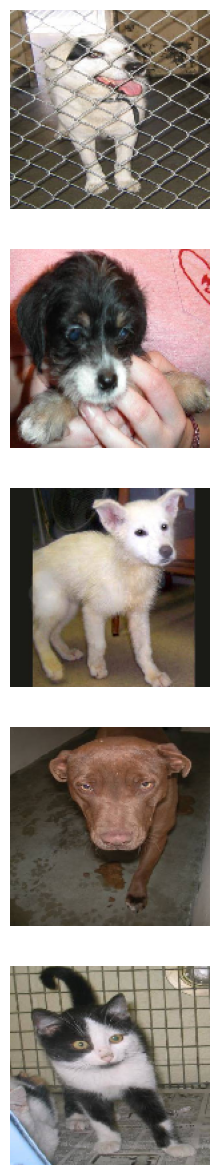

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(rotation_range=30,
                                           width_shift_range=0.25,
                                           height_shift_range=0.15,
                                           shear_range=0.27,
                                           zoom_range=0.18,
                                           horizontal_flip=True,
                                           fill_mode='nearest',
                                           rescale=1./255)


Found 2000 images belonging to 2 classes.


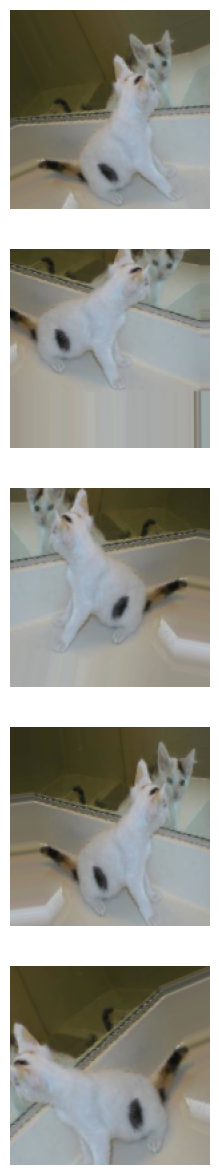

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [16]:
# 7
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu',
                 input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                 ))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Config Optimizer and CallBacks

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=500),
    tf.keras.callbacks.ModelCheckpoint(filepath='best-weight.keras', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
]

# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 148, 148, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 72, 72, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 34, 34, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 15, 15, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 5, 5, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,881 (1.65 MB)

 Trainable params: 432,881 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 8
history = model.fit(
    train_data_gen,
    batch_size = batch_size,
    #steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=100,
    validation_data=val_data_gen,
    #validation_steps=int(np.ceil(total_val / float(batch_size))),
    verbose=2, callbacks=my_callbacks
)

Epoch 1/100
16/16 - 24s - 2s/step - accuracy: 0.5065 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/100
16/16 - 37s - 2s/step - accuracy: 0.4995 - loss: 0.6928 - val_accuracy: 0.5020 - val_loss: 0.6926
Epoch 3/100
16/16 - 18s - 1s/step - accuracy: 0.5065 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 4/100
16/16 - 18s - 1s/step - accuracy: 0.4955 - loss: 0.6924 - val_accuracy: 0.5430 - val_loss: 0.6912
Epoch 5/100
16/16 - 19s - 1s/step - accuracy: 0.5350 - loss: 0.6896 - val_accuracy: 0.5330 - val_loss: 0.6894
Epoch 6/100
16/16 - 21s - 1s/step - accuracy: 0.5380 - loss: 0.6898 - val_accuracy: 0.5080 - val_loss: 0.6931
Epoch 7/100
16/16 - 20s - 1s/step - accuracy: 0.5165 - loss: 0.6913 - val_accuracy: 0.5320 - val_loss: 0.6880
Epoch 8/100
16/16 - 20s - 1s/step - accuracy: 0.5060 - loss: 0.6941 - val_accuracy: 0.5110 - val_loss: 0.6915
Epoch 9/100
16/16 - 20s - 1s/step - accuracy: 0.5160 - loss: 0.6917 - val_accuracy: 0.5270 - val_loss: 0.6901
Epoch 10/1

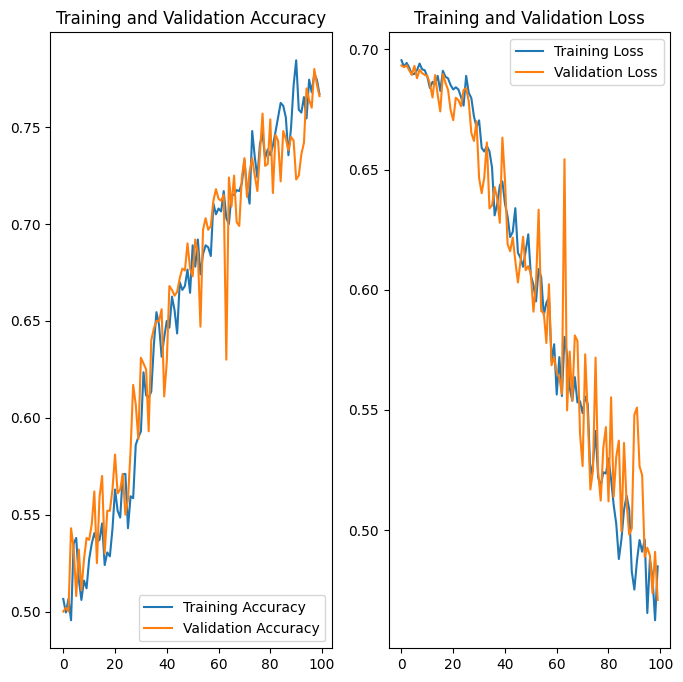

In [27]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
epochs_range

range(0, 15)

In [19]:
probabilities = model.predict(test_data_gen)[:, 0]

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


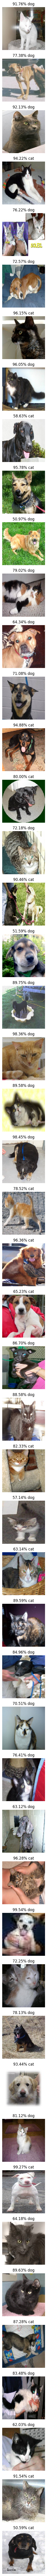

In [20]:
test_images = next(test_data_gen)
plotImages(test_images, probabilities=probabilities)

In [21]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 46.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
